In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
import sys
import dvats.utils as ut
import torch
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

import uni2ts
from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.eval_util.plot import plot_next_multi
import pyarrow.feather as ft
from gluonts.transform.split import TFTInstanceSplitter
from gluonts.transform.sampler import TestSplitSampler
import numpy as np
import einops
import torch.nn.functional as F

total length: 550


<Axes: >

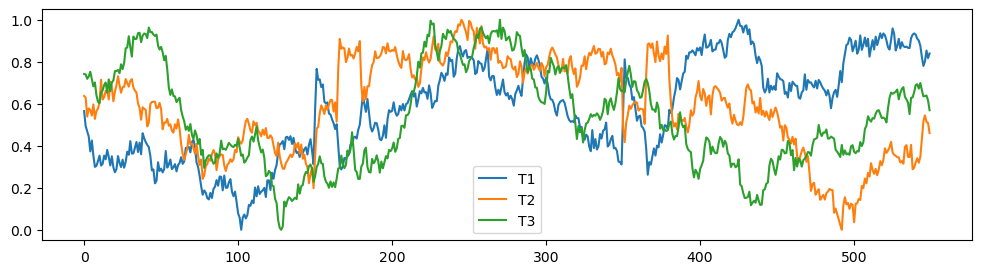

In [2]:
url = "https://zenodo.org/record/4328047/files/toy.csv?download=1"
df = pd.read_csv(url, parse_dates=True)
#df = df[df["item_id"] == "A"].drop(columns=["item_id"])
print(f"total length: {df.shape[0]}")
df.plot(figsize=(12, 3))

In [3]:
df.shape

(550, 3)

In [4]:
from gluonts.dataset.pandas import PandasDataset

In [5]:
# create a sample for the hourly data, using one week data as context window and predicting the next two days.
inp = {
    "target": df[["T1", "T2", "T3"]].to_numpy()[:168],  # 168 = 24 * 7
    "start": 0, #df.index[0].to_period(freq="H"),
}
label = {
    "target": df[["T1", "T2", "T3"]].to_numpy()[168:216],  # 48 = 24 * 2
    "start": 168, #df.index[168].to_period(freq="H"),
}


In [6]:
module = MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small")

In [7]:
inp["target"].shape

(168, 3)

In [8]:
# Prepare model
model = MoiraiForecast(
    module=module,
    prediction_length=48,
    context_length=168,
    patch_size=32,
    num_samples=100,
    target_dim=inp["target"].shape[1],
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)

In [9]:
# Time series values. Shape: (batch, time, variate)
past_target = einops.rearrange(
    torch.as_tensor(inp["target"], dtype=torch.float32), "t v-> 1 t v"
)

In [10]:
print(inp["target"].shape)
print(past_target.shape)

(168, 3)
torch.Size([1, 168, 3])


In [11]:
# 1s if the value is observed, 0s otherwise. Shape: (batch, time, variate)
past_observed_target = torch.ones_like(past_target, dtype=torch.bool)
# 1s if the value is padding, 0s otherwise. Shape: (batch, time)
past_is_pad = torch.zeros_like(past_target, dtype=torch.bool)[...,:,-1] # Kill last dimension

In [12]:
print(past_target.shape)
print(past_observed_target.shape)
print(past_is_pad.shape)

torch.Size([1, 168, 3])
torch.Size([1, 168, 3])
torch.Size([1, 168])


In [13]:
forecast = model(
    past_target=past_target,
    past_observed_target=past_observed_target,
    past_is_pad=past_is_pad,
)

_convert | patch_size ~ 32
_convert | past_target ~ torch.Size([1, 168, 3])
_convert | past_observed_target ~ torch.Size([1, 168, 3])
_convert | past_is_pad ~ torch.Size([1, 168])
_convert | future_target ~  torch.Size([1, 48, 3])
_convert | target before extend ~  0
_convert | target extend ~  2
_convert | future_observed_target ~  torch.Size([1, 48, 3])
_convert | observed_mask before extend ~  0
_convert | observed_mask extend ~  2
_convert | future_is_pad ~  torch.Size([1, 48])
_convert | sample_id before extend ~  0
_convert | sample_id after extend ~  2
_convert | time_id after extend ~  6
_convert | variate_id after extend ~  2
_convert --> |  target~torch.Size([1, 24, 128])
_convert --> |  observed_mask~ torch.Size([1, 24, 128])
_convert --> |  sample_id~torch.Size([1, 24])
_convert --> |  time_id~torch.Size([1, 24])
_convert --> |  variate_id~torch.Size([1, 24])
_convert --> |  prediction_mask~torch.Size([1, 24])
_convert | Target ~ torch.Size([1, 24, 128])
_convert | observed

In [14]:
print(past_target.shape)
print(past_observed_target.shape)
print(past_is_pad.shape)

torch.Size([1, 168, 3])
torch.Size([1, 168, 3])
torch.Size([1, 168])


In [15]:
(168//32)*3

15

In [16]:
(
    target,
    observed_mask,
    sample_id,
    time_id,
    variate_id,
    prediction_mask,
) = model._convert(
    32,
    past_target,
    past_observed_target,
    past_is_pad
)

_convert | patch_size ~ 32
_convert | past_target ~ torch.Size([1, 168, 3])
_convert | past_observed_target ~ torch.Size([1, 168, 3])
_convert | past_is_pad ~ torch.Size([1, 168])
_convert | future_target ~  torch.Size([1, 48, 3])
_convert | target before extend ~  0
_convert | target extend ~  2
_convert | future_observed_target ~  torch.Size([1, 48, 3])
_convert | observed_mask before extend ~  0
_convert | observed_mask extend ~  2
_convert | future_is_pad ~  torch.Size([1, 48])
_convert | sample_id before extend ~  0
_convert | sample_id after extend ~  2
_convert | time_id after extend ~  6
_convert | variate_id after extend ~  2
_convert --> |  target~torch.Size([1, 24, 128])
_convert --> |  observed_mask~ torch.Size([1, 24, 128])
_convert --> |  sample_id~torch.Size([1, 24])
_convert --> |  time_id~torch.Size([1, 24])
_convert --> |  variate_id~torch.Size([1, 24])
_convert --> |  prediction_mask~torch.Size([1, 24])


In [17]:
import math

In [18]:
math.ceil(48/32)

2

In [19]:
forecasts = module(
    target = target,
    observed_mask = observed_mask, 
    sample_id = sample_id,
    time_id = time_id,
    variate_id = variate_id,
    prediction_mask = prediction_mask,
    patch_size = torch.ones((target.shape[0], target.shape[1]))*32.0
)

In [20]:
forecasts

AffineTransformed()

In [21]:
? module.forward

Signature:
 module.forward(
    target: jaxtyping.Float[Tensor, '*batch seq_len max_patch'],
    observed_mask: jaxtyping.Bool[Tensor, '*batch seq_len max_patch'],
    sample_id: jaxtyping.Int[Tensor, '*batch seq_len'],
    time_id: jaxtyping.Int[Tensor, '*batch seq_len'],
    variate_id: jaxtyping.Int[Tensor, '*batch seq_len'],
    prediction_mask: jaxtyping.Bool[Tensor, '*batch seq_len'],
    patch_size: jaxtyping.Int[Tensor, '*batch seq_len'],
) -> torch.distributions.distribution.Distribution
Docstring:
Defines the forward pass of MoiraiModule.
This method expects processed inputs.

1. Apply scaling to observations
2. Project from observations to representations
3. Replace prediction window with learnable mask
4. Apply transformer layers
5. Project from representations to distribution parameters
6. Return distribution object

:param target: input data
:param observed_mask: binary mask for missing values, 1 if observed, 0 otherwise
:param sample_id: indices indicating the sample ind

In [22]:
class VerboseExecution(torch.nn.Module):
    def __init__(self, model: torch.nn.Module):
        try:
            super().__init__()
        except:
            print("Asumming model has already been initialized")
        self.model = model

        # Register a hook for each layer
        for name, layer in self.model.named_children():
            layer.__name__ = name
            layer.register_forward_hook(
                lambda layer, _, output: print(f"{layer.__name__}: {output}")
            )

    def forward(self, **module_kwargs):
        return self.model(**module_kwargs)

In [23]:
class VerboseMoiraiForecast(torch.nn.Module):
    def __init__(self, model: MoiraiForecast):
        try:
            super().__init__()
        except:
            print("Asumming model has already been initialized")
        self.model = model

        # Register a hook for each layer
        for name, layer in self.model.named_children():
            layer.__name__ = name
            layer.register_forward_hook(
                lambda layer, _, output: print(f"{layer.__name__}: {output}")
            )

    def forward(self, **module_kwargs):
        return self.model(**module_kwargs)

In [24]:
verbose_model = VerboseExecution(module)

In [25]:
? module.forward

Signature:
 module.forward(
    target: jaxtyping.Float[Tensor, '*batch seq_len max_patch'],
    observed_mask: jaxtyping.Bool[Tensor, '*batch seq_len max_patch'],
    sample_id: jaxtyping.Int[Tensor, '*batch seq_len'],
    time_id: jaxtyping.Int[Tensor, '*batch seq_len'],
    variate_id: jaxtyping.Int[Tensor, '*batch seq_len'],
    prediction_mask: jaxtyping.Bool[Tensor, '*batch seq_len'],
    patch_size: jaxtyping.Int[Tensor, '*batch seq_len'],
) -> torch.distributions.distribution.Distribution
Docstring:
Defines the forward pass of MoiraiModule.
This method expects processed inputs.

1. Apply scaling to observations
2. Project from observations to representations
3. Replace prediction window with learnable mask
4. Apply transformer layers
5. Project from representations to distribution parameters
6. Return distribution object

:param target: input data
:param observed_mask: binary mask for missing values, 1 if observed, 0 otherwise
:param sample_id: indices indicating the sample ind

In [26]:
forecasts = verbose_model(
    target = target,
    observed_mask = observed_mask,
    sample_id = sample_id,
    time_id = time_id,
    variate_id = variate_id,
    prediction_mask = prediction_mask,
    patch_size = torch.ones((target.shape[0], target.shape[1]))*32.0
)

scaler: (tensor([[[0.3261],
         [0.3261],
         [0.3261],
         [0.3261],
         [0.3261],
         [0.3261],
         [0.4834],
         [0.4834],
         [0.4834],
         [0.4834],
         [0.4834],
         [0.4834],
         [0.4883],
         [0.4883],
         [0.4883],
         [0.4883],
         [0.4883],
         [0.4883],
         [0.3261],
         [0.3261],
         [0.4834],
         [0.4834],
         [0.4883],
         [0.4883]]]), tensor([[[0.1359],
         [0.1359],
         [0.1359],
         [0.1359],
         [0.1359],
         [0.1359],
         [0.1380],
         [0.1380],
         [0.1380],
         [0.1380],
         [0.1380],
         [0.1380],
         [0.2568],
         [0.2568],
         [0.2568],
         [0.2568],
         [0.2568],
         [0.2568],
         [0.1359],
         [0.1359],
         [0.1380],
         [0.1380],
         [0.2568],
         [0.2568]]]))
in_proj: tensor([[[ 0.1473,  0.3972,  0.3520,  ...,  0.2306, -0.1476,  0.

In [27]:
verbose_model = VerboseExecution(model)

In [28]:
verbose_forecast_model = VerboseMoiraiForecast(model)

In [29]:
forecast = verbose_forecast_model(
    past_target=past_target,
    past_observed_target=past_observed_target,
    past_is_pad=past_is_pad,
)

_convert | patch_size ~ 32
_convert | past_target ~ torch.Size([1, 168, 3])
_convert | past_observed_target ~ torch.Size([1, 168, 3])
_convert | past_is_pad ~ torch.Size([1, 168])
_convert | future_target ~  torch.Size([1, 48, 3])
_convert | target before extend ~  0
_convert | target extend ~  2
_convert | future_observed_target ~  torch.Size([1, 48, 3])
_convert | observed_mask before extend ~  0
_convert | observed_mask extend ~  2
_convert | future_is_pad ~  torch.Size([1, 48])
_convert | sample_id before extend ~  0
_convert | sample_id after extend ~  2
_convert | time_id after extend ~  6
_convert | variate_id after extend ~  2
_convert --> |  target~torch.Size([1, 24, 128])
_convert --> |  observed_mask~ torch.Size([1, 24, 128])
_convert --> |  sample_id~torch.Size([1, 24])
_convert --> |  time_id~torch.Size([1, 24])
_convert --> |  variate_id~torch.Size([1, 24])
_convert --> |  prediction_mask~torch.Size([1, 24])
_convert | Target ~ torch.Size([1, 24, 128])
_convert | observed

In [30]:
predictor = verbose_forecast_model.model.create_predictor(batch_size = 32)

In [31]:
forecasts = predictor.predict(target)

In [32]:
? forecast

Type:        Tensor
String form:
tensor([[[[ 0.3411,  0.9530,  0.3353],
           [ 0.3122,  0.6123,  0.4024],
           [ 0.2464, <...> .4287,  0.1193],
           [ 0.2072,  0.5882,  0.4531],
           [ 0.4335,  0.9185,  0.3483]]]])
Length:      1
File:        /usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/__init__.py
Docstring:   <no docstring>

In [33]:
import functools

def verbose_predict(original_predict):
    @functools.wraps(original_predict)
    def wrapper(self, *args, **kwargs):
        print("Entrando a predict...")
        result = original_predict(self, *args, **kwargs)
        print("Saliendo de predict...")
        return result
    return wrapper

In [34]:
import functools
import trace

def trace_calls(frame, event, arg):
    if event != 'call':
        return
    co = frame.f_code
    func_name = co.co_name
    if func_name == 'write':
        # Ignore write() calls from printing
        return
    func_line_no = frame.f_lineno
    func_filename = co.co_filename
    print(f"Call to {func_name} on line {func_line_no} of {func_filename}")
    return trace_calls

def verbose_trace(original_func):
    tracer = trace.Trace(count=False, trace=True)
    
    @functools.wraps(original_func)
    def wrapper(*args, **kwargs):
        print("Starting trace...")
        tracer.runfunc(original_func, *args, **kwargs)
        print("Ending trace...")
        
    return wrapper


In [35]:
predictor.predict = verbose_predict(predictor.predict)

In [36]:
forecasts = predictor.predict(target)

Entrando a predict...
Saliendo de predict...


In [37]:
model.modules

<bound method Module.modules of MoiraiForecast(
  (module): MoiraiModule(
    (mask_encoding): Embedding(1, 384)
    (scaler): PackedStdScaler()
    (in_proj): MultiInSizeLinear(in_features_ls=[8, 16, 32, 64, 128], out_features=384, bias=True, dtype=torch.float32)
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): GroupedQueryAttention(
            (var_attn_bias): BinaryAttentionBias(
              (emb): Embedding(2, 6)
            )
            (time_qk_proj): QueryKeyProjection(
              (query_proj): RotaryProjection()
              (key_proj): RotaryProjection()
            )
            (q_proj): Linear(in_features=384, out_features=384, bias=False)
            (k_proj): Linear(in_features=384, out_features=384, bias=False)
            (v_proj): Linear(in_features=384, out_features=384, bias=False)
            (q_norm): RMSNorm(normalized_shape=(64,), eps=1e-05, weight=True)
            (k_norm):

In [38]:
verbose_forecast_model.model.create_predictor = verbose_trace(model.create_predictor)
predictor = verbose_forecast_model.model.create_predictor(batch_size = 32)

Starting trace...
 --- modulename: forecast, funcname: create_predictor
forecast.py(128):         ts_fields = []
forecast.py(129):         if self.hparams.feat_dynamic_real_dim > 0:
 --- modulename: hparams_mixin, funcname: hparams
hparams_mixin.py(161):         if not hasattr(self, "_hparams"):
hparams_mixin.py(163):         return self._hparams
 --- modulename: data, funcname: __getattr__
data.py(486):         try:
data.py(487):             return self[key]
forecast.py(132):         past_ts_fields = []
forecast.py(133):         if self.hparams.past_feat_dynamic_real_dim > 0:
 --- modulename: hparams_mixin, funcname: hparams
hparams_mixin.py(161):         if not hasattr(self, "_hparams"):
hparams_mixin.py(163):         return self._hparams
 --- modulename: data, funcname: __getattr__
data.py(486):         try:
data.py(487):             return self[key]
forecast.py(136):         instance_splitter = TFTInstanceSplitter(
forecast.py(137):             instance_sampler=TestSplitSampler(),


In [39]:
predictor.predict = verbose_trace(predictor.predict)
forecasts = predictor.predict(target)

AttributeError: 'NoneType' object has no attribute 'predict'

In [ ]:
# Prepare model
model = MoiraiForecast(
    module=module,
    prediction_length=48,
    context_length=168,
    patch_size=32,
    num_samples=100,
    target_dim=inp["target"].shape[1],
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)
predictor = model.create_predictor(batch_size = 32)
predictor.predict(target)
network = predictor.prediction_net

In [40]:
? model

Signature:        model(*args, **kwargs)
Type:            MoiraiForecast
String form:    
MoiraiForecast(
           (module): MoiraiModule(
           (mask_encoding): Embedding(1, 384)
           (scaler): Pa <...> s=(8, 16, 32, 64, 128), bias=True, dtype=torch.float32)
           )
           )
           )
           )
           )
           )
File:            ~/work/nbs_pipeline/uni2ts/src/uni2ts/model/moirai/forecast.py
Docstring:       <no docstring>
Class docstring: Hooks to be used in LightningModule.

In [ ]:
? network

In [ ]:
? module

In [42]:
predictor = model.create_predictor(batch_size = 32)
forecasts = predictor.predict(target)

Starting trace...
 --- modulename: forecast, funcname: create_predictor
forecast.py(128):         ts_fields = []
forecast.py(129):         if self.hparams.feat_dynamic_real_dim > 0:
 --- modulename: hparams_mixin, funcname: hparams
hparams_mixin.py(161):         if not hasattr(self, "_hparams"):
hparams_mixin.py(163):         return self._hparams
 --- modulename: data, funcname: __getattr__
data.py(486):         try:
data.py(487):             return self[key]
forecast.py(132):         past_ts_fields = []
forecast.py(133):         if self.hparams.past_feat_dynamic_real_dim > 0:
 --- modulename: hparams_mixin, funcname: hparams
hparams_mixin.py(161):         if not hasattr(self, "_hparams"):
hparams_mixin.py(163):         return self._hparams
 --- modulename: data, funcname: __getattr__
data.py(486):         try:
data.py(487):             return self[key]
forecast.py(136):         instance_splitter = TFTInstanceSplitter(
forecast.py(137):             instance_sampler=TestSplitSampler(),


AttributeError: 'NoneType' object has no attribute 'predict'